In [1]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras import optimizers
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import matplotlib.pyplot as plt
from ipynb.fs.full.utilities import *

In [4]:
class PokemonNet:
    
    @staticmethod
    def build_type1_branch(inputs, numType1, finalAct="sigmoid"):
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation(finalAct, name="type1_classification")(x)
        
        return x
        
    @staticmethod
    def build_type2_branch(inputs, numType2, finalAct="sigmoid"):
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation(finalAct, name="type2_classification")(x)
        
        return x
    
    @staticmethod
    def build_model(width, height, numType1, numType2, finalAct="sigmoid"):

        # build the VGG16 network, leaving off the top classifier layer
        # so we just get the features as output
        print('Building VGG16...')
        inputs = Input(shape=(width, height, 3))
        base_model = VGG16(weights='imagenet', 
                           include_top=False, 
                           input_tensor=inputs)
        
        type1_branch = PokemonNet.build_type1_branch(base_model.output, numType1, finalAct)
        
        print("Building model...")
        model = Model(
            inputs=inputs,
            outputs=[type1_branch],
            name="pokemonnet"
                     )
        
        return model    
        

In [10]:
EPOCHS = 50

# Creating model
model = PokemonNet.build_model(150, 150, 1, 1, "sigmoid")
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])

# Displaying model summary
model.summary()

# Extracting labels and images
data = load_images('images\images', [150, 150])

# Values between [0, 1]
data = np.array(data, dtype='float')/255.0

# Extracting labels
ptypeLabels = label_dataset('Grass', 'pokemon_2.csv')

# Split data into training and validation
split = train_test_split(data, ptypeLabels, test_size=0.2)
(trainX, testX, trainTypeY, testTypeY) = split

# train the network to perform multi-output classification
H = model.fit(trainX, trainTypeY,
        validation_data=(testX, testTypeY),
        epochs=EPOCHS,
        verbose=1)

Building VGG16...
Model: "pokemonnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37

In [11]:
# Save model
model.save('pokemon_model.h5', save_format='h5' )

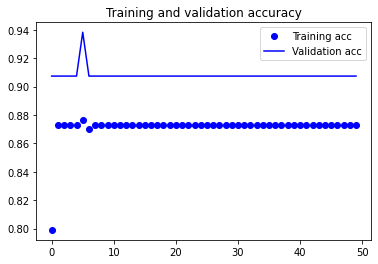

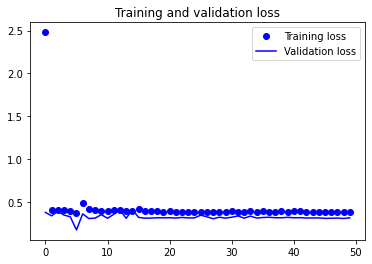

In [14]:
# Plot results

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


[INFO] loading network...
[INFO] classifying image...
Result: [[0.15579471]]


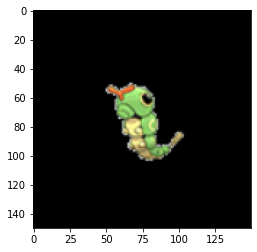

In [31]:
# Test model
MODEL_PATH='pokemon_model.h5'
TEST_IMAGE='images/images/caterpie.png'

# load the image
image = cv2.imread(TEST_IMAGE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# pre-process the image for classification
image = cv2.resize(image, (150, 150))
image = image.astype("float") / 255.0
image = img_to_array(image)
plt.imshow(image)
image = np.expand_dims(image, axis=0)

# loading model
print("[INFO] loading network...")
model = load_model(MODEL_PATH)

# classify the input image using Keras' multi-output functionality
print("[INFO] classifying image...")
x = model.predict(image)

print(f'Result: {x}')

